In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import networkx as nx
import itertools
import pandas as pd
import numpy as np
from stellargraph import StellarGraph
from tensorflow import keras
import tensorflow as tf

import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import HinSAGELinkGenerator

import matplotlib.pyplot as plt
from tensorflow.keras import mixed_precision
#mixed_precision.set_global_policy('float32')

In [2]:
g = nx.read_graphml("./graph/test_graph.gml")
species_features_dummy = pd.read_csv("./data/species_features.csv.gz", index_col=0)
molecule_features_dummy = pd.read_csv("./data/molecule_features.csv.gz", index_col=0).astype("int8")
df_agg = pd.read_csv("./data/lotus_agg_test.csv.gz", index_col=0)

In [3]:
rdkit = pd.read_csv("./data/mol_dummy_rdkit.csv.gz", index_col=0).astype('int8')
molecule_features_dummy = molecule_features_dummy.merge(rdkit,
                                                        left_index=True,
                                                        right_index=True)

In [4]:
species_feat = species_features_dummy[species_features_dummy.index.isin(df_agg.organism_name)]
molecule_feat = molecule_features_dummy[molecule_features_dummy.index.isin(df_agg.structure_smiles_2D)]

In [5]:
df_agg_train = pd.read_csv("./data/lotus_agg_train.csv.gz", index_col=0)

In [6]:
species_unique_to_test_set = df_agg[~df_agg.organism_name.isin(df_agg_train.organism_name)]
molecules_unique_to_test_set = df_agg[~df_agg.structure_smiles_2D.isin(df_agg_train.structure_smiles_2D)]

In [7]:
len(molecules_unique_to_test_set)/148190

0.2360753087252851

In [8]:
len(molecules_unique_to_test_set)

34984

In [9]:
len(species_unique_to_test_set)

3057

In [10]:
len(species_unique_to_test_set)/38000

0.08044736842105263

In [11]:
g_train = nx.read_graphml("./graph/train_graph.gml")

In [12]:
g = nx.create_empty_copy(g)
g_merged = nx.compose(g_train, g)

In [13]:
#g = nx.create_empty_copy(g)
G = StellarGraph.from_networkx(g_merged,
                               node_features={'species': species_features_dummy,
                                              'molecule':molecule_features_dummy})

In [14]:
print(G.info())
G.check_graph_for_ml()

StellarDiGraph: Directed multigraph
 Nodes: 184194, Edges: 608638

 Node types:
  molecule: [147747]
    Features: float32 vector, length 1051
    Edge types: molecule-present_in->species
  species: [36447]
    Features: float32 vector, length 69
    Edge types: species-has->molecule

 Edge types:
    species-has->molecule: [304319]
        Weights: all 1 (default)
        Features: none
    molecule-present_in->species: [304319]
        Weights: all 1 (default)
        Features: none


In [15]:
model = tf.keras.models.load_model("./model/gbif_batch_128_layer_1024_m_to_s", compile=True)

In [16]:
species_unique_to_test_set = species_unique_to_test_set[['structure_smiles_2D', 'organism_name']].to_numpy()

In [17]:
test_flow = HinSAGELinkGenerator(G,
                                 batch_size=128,
                                num_samples=[3,1],
                                head_node_types=["molecule", "species"]).flow(species_unique_to_test_set,
                                                                              np.ones(len(species_unique_to_test_set)).reshape(-1,1))

In [18]:
def predict(model, flow, iterations=10):
    predictions = []
    for _ in range(iterations):
        predictions.append(model.predict(flow, workers=-1).flatten())

    return np.mean(predictions, axis=0)

In [19]:
result = predict(model, test_flow)

24/24 [==============================] - 1s 23ms/step


In [20]:
sum(result>0.5)/len(result)

0.6797513902518809

Text(0.5, 1.0, 'Test on unknown SPECIES but known MOLECULES')

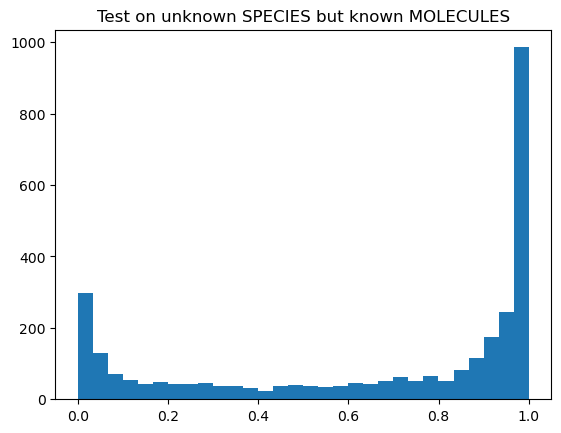

In [21]:
plt.hist(result, bins=30)
plt.title("Test on unknown SPECIES but known MOLECULES")

In [22]:
test = result[(result>0.9) | (result<0.1)]
test = test>0.5
test = test.astype('int8')

In [23]:
molecules_unique_to_test_set = molecules_unique_to_test_set[['structure_smiles_2D', 'organism_name']].to_numpy()

In [24]:
test_flow_mol = HinSAGELinkGenerator(G,
                                 batch_size=128,
                                num_samples=[3,1],
                                head_node_types=["molecule", "species"]).flow(molecules_unique_to_test_set,
                                                                              np.ones(len(molecules_unique_to_test_set)).reshape(-1,1))

In [25]:
out_mol = predict(model, test_flow_mol)

274/274 [==============================] - 6s 22ms/step


Text(0.5, 1.0, 'Test on unknown MOLECULES but known SPECIES')

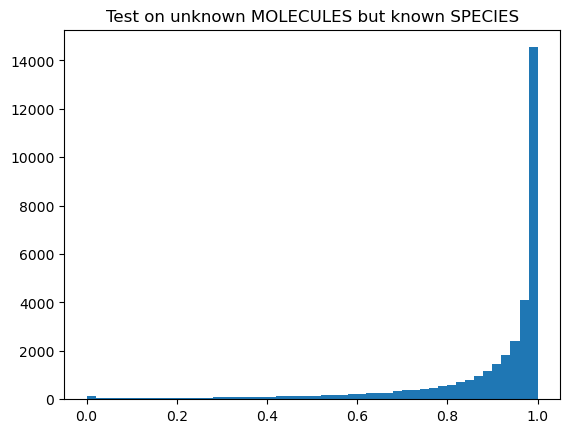

In [26]:
plt.hist(out_mol, bins=50)
plt.title("Test on unknown MOLECULES but known SPECIES")

In [27]:
sum(out_mol>0.5)/len(out_mol)

0.9429167619483192

In [28]:
molecules_unique_to_test_set

array([['CC(C)=CCCC(C)(OC1OCC(O)C(O)C1O)C1CCC2(C)C1C(O)CC1C3(C)CCC(O)C(C)(C)C3C(OC3OC(CO)C(O)C(O)C3O)CC12C',
        'Panax ginseng'],
       ['CC=C(C)C(=O)OC1CC2(C)C3CC4(OC(=O)C=C4C)OC(O)C3=CCC2C(C)(C)C1OC(=O)C(C)=CC',
        'Brickellia diffusa'],
       ['COc1cccc2c(=O)c3c(O)cc(O)c(OC)c3oc12', 'Frasera speciosa'],
       ...,
       ['CCCCCCCCCCCCCC=CC(=O)N(O)CCCCCNC(=O)CCC(=O)N(O)CCCCCNC(=O)C1COC(c2ccccc2O)=N1',
        'Nocardia'],
       ['Cc1c(O)c(C(=O)O)c(O)c2c1C(C)C(C)OC2', 'Penicillium'],
       ['CC1(C)C(=O)C=CC2(C)C1=C(O)C(=O)C1(C)C2CCC2(C)C(C3=CC(=O)OC3O)CC3OC321',
        'Walsura yunnanensis']], dtype=object)

In [29]:
out_mol

array([0.9760702 , 0.96229285, 0.9779889 , ..., 0.9966922 , 0.9982594 ,
       0.9811346 ], dtype=float32)

## Discussion

It seems like the model predicts well new molecules on known species but if new species are added, it is not able to predict which molecules will be present. 

This seems to be due to the fact that the model has been trained to predict on edges `present_in` in a "directed" way. So if the model has a new molecule, it takes its embeddings and is able to predict weather that molecule will be present or not.

I will try to create an other model that predicts the edges on `has` type. I expect it to have the opposite result. 